In [ ]:
#default_exp data.pipeline

In [ ]:
#export
from local.torch_basics import *
from local.test import *
from local.data.transform import *
from local.notebook.showdoc import show_doc

# Pipeline

> Low-level transform pipelines

The classes here provide functionality for creating a composition of *partially reversible functions*. By "partially reversible" we mean that a transform can be `decode`d, creating a form suitable for display. This is not necessarily identical to the original form (e.g. a transform that changes a byte tensor to a float tensor does not recreate a byte tensor when decoded, since that may lose precision, and a float tensor can be displayed already).

Classes are also provided and for composing transforms, and mapping them over collections. `Pipeline` is a transform which composes several `Transform`, knowing how to decode them or show an encoded item.

## Convenience functions

In [ ]:
#export
def get_func(t, name, *args, **kwargs):
    "Get the `t.name` (potentially partial-ized with `args` and `kwargs`) or `noop` if not defined"
    f = getattr(t, name, noop)
    return f if not (args or kwargs) else partial(f, *args, **kwargs)

This works for any kind of `t` supporting `getattr`, so a class or a module.

In [ ]:
test_eq(get_func(operator, 'neg', 2)(), -2)
test_eq(get_func(operator.neg, '__call__')(2), -2)
test_eq(get_func(list, 'foobar')([2]), [2])
t = get_func(torch, 'zeros', dtype=torch.int64)(5)
test_eq(t.dtype, torch.int64)
a = [2,1]
get_func(list, 'sort')(a)
test_eq(a, [1,2])

## Func -

Transforms are built with multiple-dispatch: a given function can have several methods depending on the type of the object received. This is done directly with the `multimethod` module and type-annotation in `Transform`, but you can also use the following class.

In [ ]:
#export
class Func():
    "Basic wrapper around a `name` with `args` and `kwargs` to call on a given type"
    def __init__(self, name, *args, **kwargs): self.name,self.args,self.kwargs = name,args,kwargs
    def __repr__(self): return f'sig: {self.name}({self.args}, {self.kwargs})'
    def _get(self, t): return get_func(t, self.name, *self.args, **self.kwargs)
    def __call__(self,t): return L(t).mapped(self._get) if is_listy(t) else self._get(t)

You can call the `Func` object on any module name or type, even a list of types. It will return the corresponding function (with a default to `noop` if nothing is found) or list of functions.

In [ ]:
test_eq(Func('sqrt')(math), math.sqrt)
test_eq(Func('sqrt')(torch), torch.sqrt)

@patch
def powx(x:math, a): return math.pow(x,a)
@patch
def powx(x:torch, a): return torch.pow(x,a)
tst = Func('powx',a=2)([math, torch])
test_eq([f.func for f in tst], [math.powx, torch.powx])
for t in tst: test_eq(t.keywords, {'a': 2})

In [ ]:
#export
class _Sig():
    def __getattr__(self,k):
        def _inner(*args, **kwargs): return Func(k, *args, **kwargs)
        return _inner

Sig = _Sig()

In [ ]:
show_doc(Sig, name="Sig")

<h4 id="Sig" class="doc_header"><code>Sig</code><a href="https://github.com/fastai/fastai_dev/tree/master/dev/__main__.py#L4" class="source_link" style="float:right">[source]</a></h4>

> <code>Sig</code>(**\*`args`**, **\*\*`kwargs`**)



`Sig` is just sugar-syntax to create a `Func` object more easily with the syntax `Sig.name(*args, **kwargs)`.

In [ ]:
f = Sig.sqrt()
test_eq(f(math), math.sqrt)
test_eq(f(torch), torch.sqrt)

## Pipeline -

In [ ]:
#export
def compose_tfms(x, tfms, is_enc=True, reverse=False, **kwargs):
    "Apply all `func_nm` attribute of `tfms` on `x`, maybe in `reverse` order"
    if reverse: tfms = reversed(tfms)
    for f in tfms:
        if not is_enc: f = f.decode
        x = f(x, **kwargs)
    return x

In [ ]:
def to_int  (x)  :  return Int(x)
def to_float(x):  return Float(x)
def double(x): return x*2
def half(x)->None: return x/2

In [ ]:
def test_compose(a, b, *fs):
    test_eq_type(compose_tfms(a, tfms=map(Transform,fs)), b)

test_compose(1,   Int(1),   to_int)
test_compose(1,   Float(1), to_int,to_float)
test_compose(1,   Float(2), to_int,to_float,double)
test_compose(2.0, 2.0,      to_int,double,half)

In [ ]:
class A(Transform):
    def encodes(self, x:float):  return Float(x+1)
    def decodes(self, x): return x-1
    
tfms = [A(), Transform(math.sqrt)]
t = compose_tfms(3., tfms=tfms)
test_eq_type(t, Float(2.))
test_eq(compose_tfms(t, tfms=tfms, is_enc=False), 1.)
test_eq(compose_tfms(4., tfms=tfms, reverse=True), 3.)

In [ ]:
tfms = [A(as_item=False), Transform(math.sqrt, as_item=False)]
test_eq(compose_tfms((9,3.), tfms=tfms), (3,2.))

In [ ]:
#export
def batch_to_samples(b, max_n=10):
    "'Transposes' a batch to (at most `max_n`) samples"
    if isinstance(b, Tensor): return b[:max_n]
    else:
        res = L(b).mapped(partial(batch_to_samples,max_n=max_n))
        return L(retain_types(res.zipped(), [b]))

In [ ]:
t = tensor([1,2,3])
test_eq(batch_to_samples([t,t+1], max_n=2), ([1,2],[2,3]))
test_eq(batch_to_samples(tensor([1,2,3]), 10), tensor([1, 2, 3]))
test_eq(batch_to_samples([tensor([1,2,3]), tensor([4,5,6])], 10), [(1, 4), (2, 5), (3, 6)])
test_eq(batch_to_samples([tensor([1,2,3]), tensor([4,5,6])], 2), [(1, 4), (2, 5)])
test_eq(batch_to_samples([tensor([1,2,3]), [tensor([4,5,6]),tensor([7,8,9])]], 10), 
        [(1, (4, 7)), (2, (5, 8)), (3, (6, 9))])
test_eq(batch_to_samples([tensor([1,2,3]), [tensor([4,5,6]),tensor([7,8,9])]], 2), [(1, (4, 7)), (2, (5, 8))])

t = TupleBase(tensor([1,2,3]),TensorBase([2,3,4]))
test_eq_type(batch_to_samples(t)[0][1], TensorBase(2))
test_eq(batch_to_samples(t).mapped(type), [TupleBase]*3)

In [ ]:
#export
def mk_transform(f, as_item=True):
    "Convert function `f` to `Transform` if it isn't already one"
    f = instantiate(f)
    return f if isinstance(f,Transform) else Transform(f, as_item=as_item)

In [ ]:
def neg(x): return -x
test_eq(type(mk_transform(neg)), Transform)
test_eq(type(mk_transform(math.sqrt)), Transform)
test_eq(type(mk_transform(lambda a:a*2)), Transform)

In [ ]:
#export
class Pipeline:
    "A pipeline of composed (for encode/decode) transforms, setup with types"
    def __init__(self, funcs=None, as_item=False, filt=None):
        if isinstance(funcs, Pipeline): funcs = funcs.fs
        elif isinstance(funcs, Transform): funcs = [funcs]
        self.filt,self.default = filt,None
        self.fs = L(ifnone(funcs,[noop])).mapped(mk_transform).sorted(key='order')
        self.set_as_item(as_item)
        for f in self.fs:
            name = camel2snake(type(f).__name__)
            a = getattr(self,name,None)
            if a is not None: f = L(a)+f
            setattr(self, name, f)

    def set_as_item(self, as_item):
        self.as_item = as_item
        for f in self.fs: f.as_item = as_item

    def setup(self, items=None):
        self.items = items
        tfms,self.fs = self.fs,L()
        for t in tfms: self.add(t,items)

    def add(self,t, items=None):
        t.setup(items)
        self.fs.append(t)

    def __call__(self, o): return compose_tfms(o, tfms=self.fs, filt=self.filt)
    def decode  (self, o): return compose_tfms(o, tfms=self.fs, is_enc=False, reverse=True, filt=self.filt)
    def __repr__(self): return f"Pipeline: {self.fs}"
    def __getitem__(self,i): return self.fs[i]
    def decode_batch(self, b, max_n=10): return batch_to_samples(b, max_n=max_n).mapped(self.decode)
    def __setstate__(self,data): self.__dict__.update(data)
        
    def __getattr__(self,k):
        if k.startswith('_') or k=='fs': raise AttributeError(k)
        res = [t for t in self.fs.attrgot(k) if t is not None]
        if not res: raise AttributeError(k)
        return res[0] if len(res)==1 else L(res)
            
    def show(self, o, ctx=None, **kwargs):
        for f in reversed(self.fs):
            res = self._show(o, ctx, **kwargs)
            if res is not None: return res
            o = f.decode(o, filt=self.filt)
        return self._show(o, ctx, **kwargs)

    def _show(self, o, ctx, **kwargs):
        o1 = [o] if self.as_item or not is_listy(o) else o
        if not all(hasattr(o_, 'show') for o_ in o1): return
        for o_ in o1: ctx = o_.show(ctx=ctx, **kwargs)
        return ifnone(ctx,1)

In [ ]:
add_docs(Pipeline,
         __call__="Compose `__call__` of all `fs` on `o`",
         decode="Compose `decode` of all `fs` on `o`",
         show="Show `o`, a single item from a tuple, decoding as needed",
         add="Add transform `t`",
         decode_batch="`decode` all sample in a the batch `b`",
         set_as_item="Set value of `as_item` for all transforms",
         setup="Call each tfm's `setup` in order")

`Pipeline` is a wrapper for `compose_tfm`. You can pass instances of `Transform` or regular functions in `funcs`, the `Pipeline` will wrap them all in `Transform` (and instantiate them if needed) during the initialization. It handles the transform `setup` by adding them one at a time and calling setup on each, goes through them in order in `__call__` or `decode` and can `show` an object by applying decoding the transforms up until the point it gets an object that knows how to show itself.

In [ ]:
# Empty pipeline is noop
pipe = Pipeline()
test_eq(pipe(1), 1)
pipe.set_as_item(False)
test_eq(pipe((1,)), (1,))
# Check pickle works
assert pickle.loads(pickle.dumps(pipe))

In [ ]:
class IntFloatTfm(Transform):
    def encodes(self, x):  return Int(x)
    def decodes(self, x):  return Float(x)
    foo=1

int_tfm=IntFloatTfm()

def neg(x): return -x
neg_tfm = Transform(neg, neg)

In [ ]:
pipe = Pipeline([neg_tfm, int_tfm])

start = 2.0
t = pipe(start)
test_eq_type(t, Int(-2))
test_eq_type(pipe.decode(t), Float(start))
test_stdout(lambda:pipe.show(t), '-2')

pipe.set_as_item(False)
test_stdout(lambda:pipe.show(pipe((1.,2.))), '-1\n-2')

Transforms are available as attributes named with the snake_case version of the names of their types. Attributes in transforms can be directly accessed as attributes of the pipeline.

In [ ]:
test_eq(pipe.int_float_tfm, int_tfm)
test_eq(pipe.foo, 1)

pipe = Pipeline([int_tfm, int_tfm])
pipe.int_float_tfm
test_eq(pipe.int_float_tfm[0], int_tfm)
test_eq(pipe.foo, [1,1])

In [ ]:
# Check opposite order
pipe = Pipeline([int_tfm,neg_tfm])
t = pipe(start)
test_eq(t, -2)
test_stdout(lambda:pipe.show(t), '-2')

In [ ]:
class A(Transform):
    def encodes(self, x):  return int(x)
    def decodes(self, x):  return Float(x)
    
pipe = Pipeline([neg_tfm, A])
t = pipe(start)
test_eq_type(t, -2)
test_eq_type(pipe.decode(t), Float(start))
test_stdout(lambda:pipe.show(t), '-2.0')

In [ ]:
s2 = (1,2)
pipe.set_as_item(False)
t = pipe(s2)
test_eq_type(t, (-1,-2))
test_eq_type(pipe.decode(t), (Float(1.),Float(2.)))
test_stdout(lambda:pipe.show(t), '-1.0\n-2.0')

In [ ]:
class B(Transform):
    def encodes(self, x): return x+1
    def decodes(self, x): return x-1

In [ ]:
from PIL import Image

def f1(x:TensorImage): return -x
def f2(x): return Image.open(x).resize((128,128))
def f3(x:Image.Image): return(TensorImage(array(x)))

In [ ]:
pipe = Pipeline([f2,f3,f1])
t = pipe(TEST_IMAGE)
test_eq(type(t), TensorImage)
test_eq(t, -tensor(f3(f2(TEST_IMAGE))))

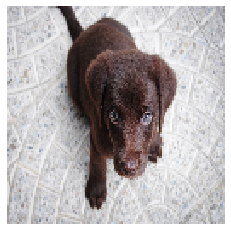

In [ ]:
pipe = Pipeline([f2,f3])
t = pipe(TEST_IMAGE)
ax = pipe.show(t)

In [ ]:
test_fig_exists(ax)

In [ ]:
#Check filtering is properly applied
add1 = B()
add1.filt = 1
pipe = Pipeline([neg_tfm, A(), add1])
test_eq(pipe(start), -2)
pipe.filt=1
test_eq(pipe(start), -1)
pipe.filt=0
test_eq(pipe(start), -2)
for t in [None, 0, 1]:
    pipe.filt=t
    test_eq(pipe.decode(pipe(start)), start)
    test_stdout(lambda: pipe.show(pipe(start)), "-2.0")

### Methods

In [ ]:
#TODO: method examples

In [ ]:
show_doc(Pipeline.__call__)

<h4 id="Pipeline.__call__" class="doc_header"><code>Pipeline.__call__</code><a href="https://github.com/fastai/fastai_dev/tree/master/dev/__main__.py#L29" class="source_link" style="float:right">[source]</a></h4>

> <code>Pipeline.__call__</code>(**`o`**)

Compose `__call__` of all `fs` on `o`

In [ ]:
show_doc(Pipeline.decode)

<h4 id="Pipeline.decode" class="doc_header"><code>Pipeline.decode</code><a href="https://github.com/fastai/fastai_dev/tree/master/dev/__main__.py#L30" class="source_link" style="float:right">[source]</a></h4>

> <code>Pipeline.decode</code>(**`o`**)

Compose `decode` of all `fs` on `o`

In [ ]:
show_doc(Pipeline.decode_batch)

<h4 id="Pipeline.decode_batch" class="doc_header"><code>Pipeline.decode_batch</code><a href="https://github.com/fastai/fastai_dev/tree/master/dev/__main__.py#L33" class="source_link" style="float:right">[source]</a></h4>

> <code>Pipeline.decode_batch</code>(**`b`**, **`max_n`**=*`10`*)

`decode` all sample in a the batch `b`

In [ ]:
pipe.set_as_item(False)
t = tensor([1,2,3])
pipe.filt=1
test_eq(pipe.decode_batch([t,t+1], max_n=2), [(0,-1),(-1,-2)])

In [ ]:
show_doc(Pipeline.setup)

<h4 id="Pipeline.setup" class="doc_header"><code>Pipeline.setup</code><a href="https://github.com/fastai/fastai_dev/tree/master/dev/__main__.py#L20" class="source_link" style="float:right">[source]</a></h4>

> <code>Pipeline.setup</code>(**`items`**=*`None`*)

Call each tfm's `setup` in order

During the setup, the `Pipeline` starts with no transform and adds them one at a time, so that during its setup, each transform gets the items processed up to its point and not after.

In [ ]:
#hide
#Test is below with TfmdList

## TfmdList -

In [ ]:
#exports
def decode_at(o, idx):
    "Decoded item at `idx`"
    return o.decode(o[idx])

In [ ]:
#exports
def show_at(o, idx, **kwargs):
    "Show item at `idx`",
    return o.show(o[idx], **kwargs)

In [ ]:
#export
class FilteredBase:
    "Mixin class for lists with subsets"
    def __init__(self, *args, filts=None, **kwargs):
        self.filts = L([slice(None)] if filts is None else filts).mapped(mask2idxs)
        super().__init__(*args, **kwargs)

    def _new(self, items, **kwargs): return super()._new(items, filts=self.filts, **kwargs)
    def subsets(self): return map(self.subset, range_of(self.filts))
    def subset(self, i): return self._new(self._get(self.filts[i]), filt=i)
        
FilteredBase.train,FilteredBase.valid = add_props(lambda i,x: x.subset(i), 2)

In [ ]:
#export
class TfmdList(FilteredBase, L):
    "A `Pipeline` of `tfms` applied to a collection of `items`"
    def __init__(self, items, tfms, use_list=None, do_setup=True, as_item=True, filt=None, train_setup=True, filts=None):
        super().__init__(items, use_list=use_list, filts=filts)
        if isinstance(tfms,TfmdList): tfms = tfms.tfms
        if isinstance(tfms,Pipeline): do_setup=False
        self.tfms = Pipeline(tfms, as_item=as_item, filt=filt)
        if do_setup: self.setup(train_setup=train_setup)

    def _new(self, items, **kwargs): return super()._new(items, tfms=self.tfms, do_setup=False, **kwargs)
    def _after_item(self, o): return self.tfms(o)
    def __repr__(self): return f"{self.__class__.__name__}: {self.items}\ntfms - {self.tfms.fs}"
    def __iter__(self): return (self[i] for i in range(len(self)))
    def show(self, o, **kwargs): return self.tfms.show(o, **kwargs)
    def decode(self, x, **kwargs): return self.tfms.decode(x, **kwargs)
    def __call__(self, x, **kwargs): return self.tfms.__call__(x, **kwargs)
    
    def __getitem__(self, idx):
        res = super().__getitem__(idx)
        if self._after_item is None: return res
        return self._after_item(res) if is_indexer(idx) else res.mapped(self._after_item)

    def setup(self, train_setup=True):
        if train_setup: self.items,old_items = self._get(self.filts[0]),self.items
        self.tfms.setup(self)
        if train_setup: self.items = old_items

In [ ]:
add_docs(TfmdList,
         setup="Transform setup with self",
         decode="From `Pipeline",
         show="From `Pipeline",
         subsets="List of all `subset`s",
         subset="New `TfmdList` that only includes subset `i`")

A `TfmdList` combines a collection of object with a `Pipeline`. `tfms` can either be a `Pipeline` or a list of transforms, in which case, it will wrap them in a `Pipeline`. `use_list` is passed along to `L` with the `items`, `as_item` and `filt` are passed to each transform of the `Pipeline`. `do_setup` indicates if the `Pipeline.setup` method should be called during initialization.

In [ ]:
tl = TfmdList([1.,2.,3.], [neg_tfm, int_tfm], filts=[[0,2],[1]])
t = tl[1]
test_eq_type(t, Int(-2))
test_eq(decode_at(tl, 1), 2)
test_eq_type(tl.decode(t), Float(2.0))
test_stdout(lambda: show_at(tl, 2), '-3')
tl

TfmdList: [1.0, 2.0, 3.0]
tfms - (#2) [Transform: True {'object': 'neg'} {'object': 'neg'},IntFloatTfm: True {'object': 'encodes'} {'object': 'decodes'}]

In [ ]:
tl = TfmdList([1.,2.,3.], [neg_tfm, int_tfm, add1], filts=[[0,2],[1]])
test_eq(tl[0], -1)
test_eq(tl[1], -2)
test_eq(tl.valid[0], -1) #add1 is only applied on the validation set

In [ ]:
p2 = tl.subset(0)
test_eq(p2, [-1,-3])
test_eq(map(type, p2), (Int,Int))
test_eq(tl[tensor(1)], tl[1])

In [ ]:
df = pd.DataFrame(dict(a=[1,2,3],b=[2,3,4]))
tl = TfmdList(df, lambda o: o.a, filts=[[0],[1,2]])
test_eq(tl[1,2], [2,3])
p2 = tl.subset(1)
test_eq(p2, [2,3])

In [ ]:
class B(Transform):
    def __init__(self):   self.a = 2
    def encodes(self, x): return x+self.a
    def decodes(self, x): return x-self.a
    def setups(self, items): self.a = tensor(items).float().mean().item()

tl1 = TfmdList([1,2,3,4], B())
test_eq(tl1.tfms[0].a, 2.5)

In [ ]:
tfilts = [tensor([0,2]), [1,3,4]]

In [ ]:
tl = TfmdList(range(5), tfms=[None], filts=tfilts)
test_eq(len(tl.filts), 2)
test_eq(tl.subset(0), [0,2])
test_eq(tl.train, [0,2])       # Subset 0 is aliased to `train`
test_eq(tl.subset(1), [1,3,4])
test_eq(tl.valid, [1,3,4])     # Subset 1 is aliased to `valid`
test_eq(tl.valid[2], 4)

Here's how we can use `TfmdList.setup` to implement a simple category list, getting labels from a mock file list:

In [ ]:
class _Cat(Transform):
    order = 1
    def encodes(self, o):    return int(self.o2i[o])
    def decodes(self, o):    return Str(self.vocab[o])
    def setups(self, items): self.vocab,self.o2i = uniqueify(L(items), sort=True, bidir=True)

def _lbl(o):  return Str(o.split('_')[0])
test_fns = ['dog_0.jpg','cat_0.jpg','cat_2.jpg','cat_1.jpg','dog_1.jpg']
tcat = _Cat()
# Check that tfms are sorted by `order`
tl = TfmdList(test_fns, [tcat,_lbl])

test_eq(tcat.vocab, ['cat','dog'])

In [ ]:
test_eq(tl, (1,0,0,0,1))
t = L(tl)
test_eq(t, [1,0,0,0,1])
test_eq(tl[-1], 1)
test_eq(tl[0,1], (1,0))
test_eq([tl.decode(o) for o in t], ('dog','cat','cat','cat','dog'))
test_stdout(lambda:show_at(tl, 0), "dog")
tl

TfmdList: ['dog_0.jpg', 'cat_0.jpg', 'cat_2.jpg', 'cat_1.jpg', 'dog_1.jpg']
tfms - (#2) [Transform: True {'object': '_lbl'} {},_Cat: True {'object': 'encodes'} {'object': 'decodes'}]

In [ ]:
test_fns = ['dog_0.jpg','cat_0.jpg','cat_2.jpg','cat_1.jpg','dog_1.jpg','kid_05.jpg']
tcat = _Cat()
tl = TfmdList(test_fns, [tcat,_lbl], filts=[[0,1,2,3,4], [5]])
#Check only the training set is taken into account for setup
test_eq(tcat.vocab, ['cat','dog'])

### Methods

In [ ]:
show_doc(TfmdList.subset)

<h4 id="FilteredBase.subset" class="doc_header"><code>FilteredBase.subset</code><a href="https://github.com/fastai/fastai_dev/tree/master/dev/__main__.py#L10" class="source_link" style="float:right">[source]</a></h4>

> <code>FilteredBase.subset</code>(**`i`**)

New [`TfmdList`](/data.pipeline.html#TfmdList) that only includes subset `i`

In [ ]:
show_doc(TfmdList.subsets)

<h4 id="FilteredBase.subsets" class="doc_header"><code>FilteredBase.subsets</code><a href="https://github.com/fastai/fastai_dev/tree/master/dev/__main__.py#L9" class="source_link" style="float:right">[source]</a></h4>

> <code>FilteredBase.subsets</code>()

List of all `subset`s

## TfmdDS -

In [ ]:
#export
@docs
@delegates(TfmdList)
class DataSource(FilteredBase):
    "A dataset that creates a tuple from each `tfms`, passed thru `ds_tfms`"
    def __init__(self, items=None, tfms=None, tls=None, **kwargs):
        self.tls = tls if tls else L(TfmdList(items, t, **kwargs) for t in L(ifnone(tfms,[None])))

    def __getitem__(self, it):
        res = tuple([tl[it] for tl in self.tls])
        return res if is_indexer(it) else list(zip(*res))
    
    def __len__(self): return len(self.tls[0])
    def __iter__(self): return (self[i] for i in range(len(self)))
    def __repr__(self): return coll_repr(self)
    def decode(self, o): return tuple(tl.decode(o_) for o_,tl in zip(o,self.tls))
    def subset(self, i): return DataSource(tls=[tl.subset(i) for tl in self.tls])
    def _new(self, items, *args, **kwargs): return super()._new(items, tfms=self.tfms, do_setup=False, **kwargs)
    @property
    def filts(self): return self.tls[0].filts
    def show(self, o, ctx=None, **kwargs):
        for o_,tl in zip(o,self.tls): ctx = tl.show(o_, ctx=ctx, **kwargs)
        return ctx

    _docs=dict(
        decode="Compose `decode` of all `tuple_tfms` then all `tfms` on `i`",
        show="Show item `o` in `ctx`",
        subset="New `DataSource` that only includes subset `i`")

A `TfmdDS` creates a tuple from `items` (typically input,target) by applying each list of `Transform` (or `Pipeline`) in `tfms` to them. Note that if `tfms` contains only one list of `tfms`, the items given by `TfmdDS` will be tuples of one element.

In [ ]:
items = [1,2,3,4]
dsrc = DataSource(items, [[neg_tfm,int_tfm]])
test_eq(*dsrc[0], -1)
test_eq(dsrc[0,1,2], [(-1,),(-2,),(-3,)])

In [ ]:
class A(Transform):
    def encodes(self, o): return (o-self.m)/self.s
    def decodes(self, o): return (o*self.s)+self.m
    def setups(self, items):
        its = tensor(items).float()
        self.m,self.s = its.mean(),its.std()

In [ ]:
items = [1,2,3,4]
nrm = A()
dsrc = DataSource(items, [[neg_tfm,int_tfm], [neg_tfm,nrm]])

x,y = zip(*dsrc)
test_close(tensor(y).mean(), 0)
test_close(tensor(y).std(), 1)
test_eq(x, (-1,-2,-3,-4,))
test_eq(nrm.m, -2.5)
test_stdout(lambda:show_at(dsrc, 1), '-2')
#TODO: do something here
# test_eq(dsrc.m, dsrc.type_tfms[1].fs[1].m)
# test_eq(dsrc.s, dsrc.type_tfms[1].fs[1].s)
#Attributes are set to all parents progressively
# test_eq(dsrc.tls[1].m, dsrc.type_tfms[1].fs[1].m)
# test_eq(dsrc.tls[1].s, dsrc.type_tfms[1].fs[1].s)

In [ ]:
#hide
#Check filtering is properly applied
class B(Transform):
    def encodes(self, x)->None:  return int(x+1)
    def decodes(self, x):        return Int(x-1)
add1 = B(filt=1)

dsrc = DataSource(items, [neg_tfm, [neg_tfm,int_tfm,add1]], filts=[[3],[0,1,2]])
test_eq(dsrc[1], [-2,-2])
test_eq(dsrc.valid[1], [-2,-1])
test_eq(dsrc.valid[[1,1]], [[-2,-1], [-2,-1]])
test_eq(dsrc.train[0], [-4,-4])

In [ ]:
#hide
#Test setup works with train attribute
def _lbl(o): return o.split('_')[0]

test_fns = ['dog_0.jpg','cat_0.jpg','cat_2.jpg','cat_1.jpg','kid_1.jpg']
tcat = _Cat()
dsrc = DataSource(test_fns, [[tcat,_lbl]], filts=[[0,1,2], [3,4]])
test_eq(tcat.vocab, ['cat','dog'])
test_eq(dsrc.train, [(1,),(0,),(0,)])
test_eq(dsrc.valid[0], (0,))
test_stdout(lambda: show_at(dsrc.train, 0), "dog")

In [ ]:
inp = [0,1,2,3,4]
dsrc = DataSource(inp, tfms=[None])

test_eq(*dsrc[2], 2)          # Retrieve one item (subset 0 is the default)
test_eq(dsrc[1,2], [(1,),(2,)])    # Retrieve two items by index
mask = [True,False,False,True,False]
test_eq(dsrc[mask], [(0,),(3,)])   # Retrieve two items by mask

In [ ]:
inp = pd.DataFrame(dict(a=[5,1,2,3,4]))
dsrc = DataSource(inp, tfms=attrgetter('a')).subset(0)
test_eq(*dsrc[2], 2)          # Retrieve one item (subset 0 is the default)
test_eq(dsrc[1,2], [(1,),(2,)])    # Retrieve two items by index
mask = [True,False,False,True,False]
test_eq(dsrc[mask], [(5,),(3,)])   # Retrieve two items by mask

In [ ]:
# filts can be indices
dsrc = DataSource(range(5), tfms=[None], filts=[tensor([0,2]), [1,3,4]])

test_eq(dsrc.subset(0), [(0,),(2,)])
test_eq(dsrc.train, [(0,),(2,)])       # Subset 0 is aliased to `train`
test_eq(dsrc.subset(1), [(1,),(3,),(4,)])
test_eq(dsrc.valid, [(1,),(3,),(4,)])     # Subset 1 is aliased to `valid`
test_eq(*dsrc.valid[2], 4)
#assert '[(1,),(3,),(4,)]' in str(dsrc) and '[(0,),(2,)]' in str(dsrc)
dsrc

(#5) [(0,),(1,),(2,),(3,),(4,)]

In [ ]:
# filts can be boolean masks (they don't have to cover all items, but must be disjoint)
filts = [[False,True,True,False,True], [True,False,False,False,False]]
dsrc = DataSource(range(5), tfms=[None], filts=filts)

test_eq(dsrc.train, [(1,),(2,),(4,)])
test_eq(dsrc.valid, [(0,)])

In [ ]:
# apply transforms to all items
tfm = [[lambda x: x*2,lambda x: x+1]]
filts = [[1,2],[0,3,4]]
dsrc = DataSource(range(5), tfm, filts=filts)
test_eq(dsrc.train,[(3,),(5,)])
test_eq(dsrc.valid,[(1,),(7,),(9,)])
test_eq(dsrc.train[False,True], [(5,)])

In [ ]:
# only transform subset 1
class _Tfm(Transform):
    filt=1
    def encodes(self, x): return x*2
    def decodes(self, x): return Str(x//2)

In [ ]:
dsrc = DataSource(range(5), [_Tfm()], filts=[[1,2],[0,3,4]])
test_eq(dsrc.train,[(1,),(2,)])
test_eq(dsrc.valid,[(0,),(6,),(8,)])
test_eq(dsrc.train[False,True], [(2,)])
dsrc

(#5) [(0,),(1,),(2,),(3,),(4,)]

In [ ]:
#hide
#Test DataSource pickles
dsrc1 = pickle.loads(pickle.dumps(dsrc))
test_eq(dsrc.train, dsrc1.train)
test_eq(dsrc.valid, dsrc1.valid)
#test_eq(dsrc1.vocab, ['cat','dog'])

In [ ]:
dsrc = DataSource(range(5), [_Tfm(),noop], filts=[[1,2],[0,3,4]])
test_eq(dsrc.train,[(1,1),(2,2)])
test_eq(dsrc.valid,[(0,0),(6,3),(8,4)])

### Methods

In [ ]:
items = [1,2,3,4]
dsrc = DataSource(items, [[neg_tfm,int_tfm]])

In [ ]:
show_doc(DataSource.decode)

<h4 id="DataSource.decode" class="doc_header"><code>DataSource.decode</code><a href="https://github.com/fastai/fastai_dev/tree/master/dev/__main__.py#L16" class="source_link" style="float:right">[source]</a></h4>

> <code>DataSource.decode</code>(**`o`**)

Compose `decode` of all `tuple_tfms` then all `tfms` on `i`

In [ ]:
test_eq(*dsrc[0], -1)
test_eq(*dsrc.decode((-1,)), 1)

In [ ]:
show_doc(DataSource.show)

<h4 id="DataSource.show" class="doc_header"><code>DataSource.show</code><a href="https://github.com/fastai/fastai_dev/tree/master/dev/__main__.py#L21" class="source_link" style="float:right">[source]</a></h4>

> <code>DataSource.show</code>(**`o`**, **`ctx`**=*`None`*, **\*\*`kwargs`**)

Show item `o` in `ctx`

In [ ]:
test_stdout(lambda:dsrc.show(dsrc[1]), '-2')

## Export -

In [ ]:
#hide
from local.notebook.export import notebook2script
notebook2script(all_fs=True)

Converted 00_test.ipynb.
Converted 01_core.ipynb.
Converted 01a_torch_core.ipynb.
Converted 01b_script.ipynb.
Converted 01c_dataloader.ipynb.
Converted 02_data_transforms.ipynb.
Converted 03_data_pipeline.ipynb.
Converted 05_data_core.ipynb.
Converted 07_vision_core.ipynb.
Converted 08_pets_tutorial.ipynb.
Converted 09_vision_augment.ipynb.
Converted 11_layers.ipynb.
Converted 11a_vision_models_xresnet.ipynb.
Converted 12_optimizer.ipynb.
Converted 13_learner.ipynb.
Converted 14_callback_schedule.ipynb.
Converted 15_callback_hook.ipynb.
Converted 16_callback_progress.ipynb.
Converted 17_callback_tracker.ipynb.
Converted 18_callback_fp16.ipynb.
Converted 19_callback_mixup.ipynb.
Converted 20_metrics.ipynb.
Converted 21_tutorial_imagenette.ipynb.
Converted 22_vision_learner.ipynb.
Converted 23_tutorial_transfer_learning.ipynb.
Converted 30_text_core.ipynb.
Converted 31_text_data.ipynb.
Converted 32_text_models_awdlstm.ipynb.
Converted 33_text_models_core.ipynb.
Converted 34_callback_rnn.